<a href="https://colab.research.google.com/github/Akash12-sudo/Skin_disease_detection/blob/main/Copy_of_Skin_Disease_Detection_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
## Connecting to the google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Unzipping the zipped folder containing dataset
import zipfile
dataset_ref = zipfile.ZipFile('/content/drive/MyDrive/project_data.zip')
dataset_ref.extractall('/content')
dataset_ref.close()

In [11]:
# Data Processing Step
train_dir = '/content/project_data/train'
test_dir = '/content/project_data/test'
num_classes = 4

## Data augmentation technique to prevent overfitting
# training dataset generator 
train_datagen = ImageDataGenerator(        
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split = 0.2  # set aside 10% of training data for validation
)

# testing dataset generator
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

### Loading the dataset
# training dataset
train_ds = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (256, 256),
    class_mode = "categorical",
    batch_size = 32,
    subset = "training"
)

# validation dataset
val_ds = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (256, 256),
    class_mode = "categorical",
    subset = "validation"
)

# test dataset
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size = (256, 256),
    class_mode = "categorical"
)



Found 3449 images belonging to 4 classes.
Found 861 images belonging to 4 classes.
Found 1181 images belonging to 4 classes.


In [10]:
# Importing the Inception-V3 model
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [12]:
# Connecting with inception-v3 model
model = Sequential()
model.add(base_model)
model.add(Flatten())

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation = 'sigmoid'))

for layer in base_model.layers:
  layer.trainable = False

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 1024)              75498496  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2

In [15]:
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
file_path = '/content/best_models/model-{epoch:02d}-{val_accuracy:.2f}.hdf5'

In [18]:
checkpoint = ModelCheckpoint(file_path, monitor = "val_accuracy", verbose = 1, save_best_only=True, mode = "max")

In [19]:
hist = model.fit(train_ds, validation_data = val_ds, epochs = 10, callbacks = [checkpoint])

Epoch 1/10
108/108 [==============================] - ETA: 0s - loss: 2.5158 - accuracy: 0.3842
Epoch 1: val_accuracy improved from -inf to 0.44599, saving model to /content/best_models/model-01-0.45.hdf5
108/108 [==============================] - 115s 942ms/step - loss: 2.5158 - accuracy: 0.3842 - val_loss: 1.2714 - val_accuracy: 0.4460
Epoch 2/10
108/108 [==============================] - ETA: 0s - loss: 1.2160 - accuracy: 0.4633
Epoch 2: val_accuracy improved from 0.44599 to 0.49477, saving model to /content/best_models/model-02-0.49.hdf5
108/108 [==============================] - 96s 893ms/step - loss: 1.2160 - accuracy: 0.4633 - val_loss: 1.1925 - val_accuracy: 0.4948
Epoch 3/10
108/108 [==============================] - ETA: 0s - loss: 1.1647 - accuracy: 0.5077
Epoch 3: val_accuracy improved from 0.49477 to 0.49710, saving model to /content/best_models/model-03-0.50.hdf5
108/108 [==============================] - 96s 887ms/step - loss: 1.1647 - accuracy: 0.5077 - val_loss: 1.1538

In [20]:
from tensorflow.keras.metrics import Recall, Precision, Accuracy, CategoricalAccuracy

In [21]:
recall = Recall()
precision = Precision()
accuracy = Accuracy()

In [22]:
y_pred = model.predict(test_ds)

37/37 [==============================] - 12s 293ms/step


In [23]:
y_pred = np.argmax(y_pred, axis=1)

In [24]:
y_pred

array([3, 1, 1, ..., 3, 2, 3])

In [25]:
y_true = test_ds.classes

In [26]:
y_true

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [27]:
recall.update_state(y_true, y_pred)
precision.update_state(y_true, y_pred)
accuracy.update_state(y_true, y_pred)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1181.0>

In [28]:
print(f'Recall: {recall.result().numpy()}\nPrecision: {precision.result().numpy()}\nAccuracy: {accuracy.result().numpy()}')

Recall: 0.8193325400352478
Precision: 0.7424400448799133
Accuracy: 0.2574089765548706


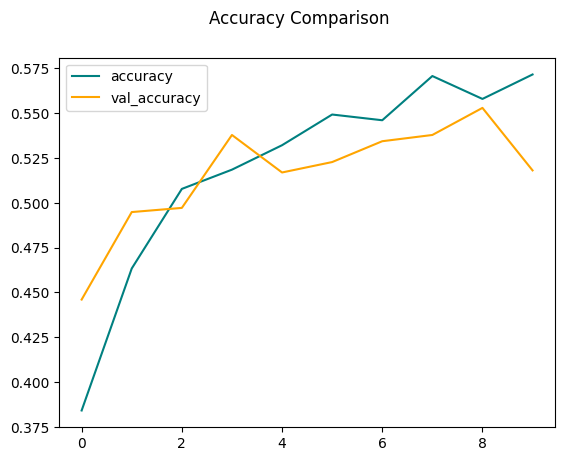

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy Comparison')
plt.legend(loc = "upper left")
plt.show()

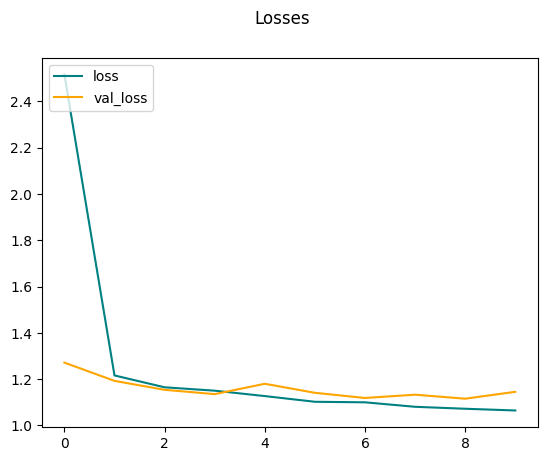

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Losses')
plt.legend(loc = "upper left")
plt.show()